Baseline Models = Logistic Regression and Decision Trees

In [1]:
# necessary modules
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


In [2]:
# import dataset
merged_df = pd.read_csv('merged_df.csv')

Preprocessing Pipeline

In [26]:
# Define target variables and feature variables
X = merged_df.drop(columns=['DEP_DATE_TIME', 'ACC_DEP_TIME', 'DEP_DELAY_NEW', 'DEP_DELAY_GROUP'])
y = merged_df['DEP_DELAY_GROUP']

# Replace -2 and -1 with 0 in the target labels
y = y.replace({-2: 0, -1: 0})

# Define numerical and categorical columns 
categorical_cols = ['ORIGIN', 'DEST']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure encoder learns all categories, even those missing in training
all_categories = {col: X[col].unique() for col in categorical_cols}

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(categories=[all_categories[col] for col in categorical_cols], drop='first', handle_unknown='ignore'), categorical_cols)
    ])

# Preprocess the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get the feature names after one-hot encoding
ohe_column_names = preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols).tolist()

# Combine the numerical columns with the one-hot encoded column names
all_column_names = numerical_cols + ohe_column_names

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train_processed.toarray())  # Use toarray() if sparse matrix
Y_train = torch.LongTensor(Y_train.values)
X_test = torch.FloatTensor(X_test_processed.toarray())
Y_test = torch.LongTensor(Y_test.values)

# Normalize data
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

# Debugging: Print categories learned by OneHotEncoder
print("Categories learned by OneHotEncoder:", preprocessor.named_transformers_['cat'].categories_)

Categories learned by OneHotEncoder: [array(['JFK'], dtype=object), array(['LAX', 'SFO', 'SJU', 'PHX', 'TPA', 'RSW', 'FLL', 'PBI', 'BQN',
       'MCO', 'ATL', 'MIA', 'STT', 'MSY', 'LAS', 'BOS', 'SLC', 'SRQ',
       'MSP', 'BUR', 'DEN', 'HOU', 'LGB', 'SYR', 'JAX', 'SEA', 'AUS',
       'PWM', 'RIC', 'RDU', 'OAK', 'IAD', 'DTW', 'ORD', 'BTV', 'BUF',
       'ROC', 'SAN', 'DCA', 'CLT', 'PIT', 'CVG', 'PHL', 'BWI', 'EGE',
       'MCI', 'BGR', 'CLE', 'SJC', 'SMF', 'ALB', 'BDL', 'IAH', 'PDX',
       'IND', 'STL', 'MKE', 'BNA', 'ORF', 'PSE', 'DFW', 'CMH', 'MEM',
       'ACK', 'SNA', 'SAT', 'LWB', 'MVY', 'HNL', 'PSP', 'CHS', 'SDF',
       'ABQ', 'BHM', 'JAC', 'SAV', 'HYA', 'RNO', 'DAB', 'TUS', 'ORH'],
      dtype=object)]


Multinomial Logistic Regression

Epoch [10/100], Loss: 2.5830, Accuracy: 0.1131
Epoch [20/100], Loss: 2.5106, Accuracy: 0.1636
Epoch [30/100], Loss: 2.4396, Accuracy: 0.2266
Epoch [40/100], Loss: 2.3701, Accuracy: 0.2960
Epoch [50/100], Loss: 2.3021, Accuracy: 0.3663
Epoch [60/100], Loss: 2.2357, Accuracy: 0.4325
Epoch [70/100], Loss: 2.1709, Accuracy: 0.4915
Epoch [80/100], Loss: 2.1078, Accuracy: 0.5439
Epoch [90/100], Loss: 2.0465, Accuracy: 0.5902
Epoch [100/100], Loss: 1.9869, Accuracy: 0.6308

Training Set Metrics:
Accuracy: 0.6344
Precision: 0.7823
Recall: 0.6344
F1-score: 0.6995

Test Set Metrics:
Accuracy: 0.6336
Precision: 0.7809
Recall: 0.6336
F1-score: 0.6985


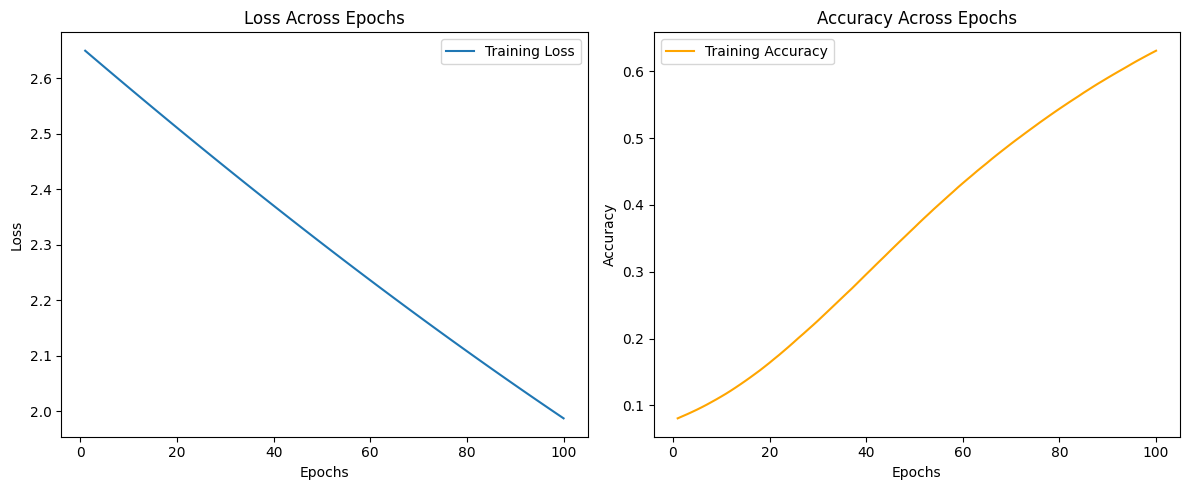

<Figure size 640x480 with 0 Axes>

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Define multinomial logistic regression model
class MultinomialLogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultinomialLogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.linear(x)  # Softmax is included in CrossEntropyLoss

# Model, loss, optimizer
input_dim = X_train.shape[1]  # Number of features after preprocessing
output_dim = len(torch.unique(Y_train))
model = MultinomialLogisticRegression(input_dim, output_dim)

criterion = nn.CrossEntropyLoss()  # Includes softmax
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Lists to store loss and accuracy for plotting
train_loss_list = []
train_accuracy_list = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Calculate accuracy for this epoch
    with torch.no_grad():
        y_pred = torch.argmax(outputs, dim=1)
        correct = (y_pred == Y_train).float()
        accuracy = correct.mean()

    # Store loss and accuracy
    train_loss_list.append(loss.item())
    train_accuracy_list.append(accuracy.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

# Evaluate metrics after training
model.eval()  # Set model to evaluation mode

# Get predictions for both training and test sets
with torch.no_grad():
    # Training set predictions
    y_pred_train = torch.argmax(model(X_train), dim=1)
    # Test set predictions
    y_pred_test = torch.argmax(model(X_test), dim=1)

# Convert predictions and labels to numpy arrays for metric calculations
y_train_np = Y_train.cpu().numpy()
y_test_np = Y_test.cpu().numpy()
y_pred_train_np = y_pred_train.cpu().numpy()
y_pred_test_np = y_pred_test.cpu().numpy()

# Calculate accuracy, precision, recall, f1-score for training and test sets
# Training set metrics
train_accuracy = accuracy_score(y_train_np, y_pred_train_np)
train_precision = precision_score(y_train_np, y_pred_train_np, average='weighted')
train_recall = recall_score(y_train_np, y_pred_train_np, average='weighted')
train_f1 = f1_score(y_train_np, y_pred_train_np, average='weighted')

# Test set metrics
test_accuracy = accuracy_score(y_test_np, y_pred_test_np)
test_precision = precision_score(y_test_np, y_pred_test_np, average='weighted')
test_recall = recall_score(y_test_np, y_pred_test_np, average='weighted')
test_f1 = f1_score(y_test_np, y_pred_test_np, average='weighted')

# Print the metrics for both training and test sets
print(f'\nTraining Set Metrics:')
print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'F1-score: {train_f1:.4f}')

print(f'\nTest Set Metrics:')
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1-score: {test_f1:.4f}')

# Plotting Loss and Accuracy across epochs
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Across Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_list, label='Training Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Across Epochs')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

# Save the plot to a file
plt.savefig('training_loss_accuracy_plot_MLR.png')

Decision Trees

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Convert PyTorch tensors to Pandas DataFrame with original column names
X_train_df = pd.DataFrame(X_train.numpy(), columns=X_train.columns)
X_test_df = pd.DataFrame(X_test.numpy(), columns=X_test.columns)

class SimpleDecisionTree:
    def __init__(self, max_depth=None, min_samples_leaf=None):
        self.model = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,  # Add minimum samples per leaf
            min_samples_split=50,               # Minimum samples required to split
            max_leaf_nodes=12                   # Limit total number of leaf nodes
        )

    def fit(self, X_train, Y_train):
        self.model.fit(X_train, Y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def get_feature_importances(self):
        return self.model.feature_importances_

# Initialize and train model with stricter parameters
model = SimpleDecisionTree(
    max_depth=2,              # Reduced depth
    min_samples_leaf=100      # Require at least 100 samples per leaf
)
model.fit(X_train_df, Y_train)

# Create figure with adjusted size
plt.figure(figsize=(20, 10))

# Plot tree with modified parameters
plot_tree(
    model.model,
    filled=True,
    feature_names=X_train_df.columns,
    class_names=np.unique(Y_train).astype(str),
    fontsize=14,
    max_depth=2,             # Match the classifier's max_depth
    proportion=True,
    precision=1,
    rounded=True,
    impurity=False,
    node_ids=False,
    label='root',
)

# Increase spacing between nodes
plt.margins(x=0.2, y=0.2)

# Add padding around the plot
plt.tight_layout(pad=2.0)

# Customize colors
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Add title with padding
plt.title("Decision Tree Visualization (Simplified)", pad=30, fontsize=16)

# Save with high DPI and tight layout
plt.savefig('decision_tree_plot.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none',
            pad_inches=0.5)

plt.show()

# Feature importance plot
plt.figure(figsize=(12, 6))
importance_data = pd.DataFrame({
    'Feature': X_train_df.columns,
    'Importance': model.get_feature_importances()
}).sort_values('Importance', ascending=True)

plt.barh(importance_data['Feature'], 
         importance_data['Importance'],
         color='skyblue',
         edgecolor='navy')

plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance in Decision Tree', fontsize=14, pad=20)
plt.tight_layout()

plt.savefig('feature_importance_plot.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

plt.show()

KeyboardInterrupt: 